# Прогнозирование заказов такси

__Описание проекта__

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час

__Цель проекта__

Нужно спрогнозировать количество заказов такси на следующий час, gостройте модель для такого предсказания.  
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

__Ход исследования__

Шаг 1. Загрузка данных и выполнение их ресемплирования по одному часу  
Шаг 2. Предобработка и анализ данных   
Шаг 3. Обучение разных моделей с различными гиперпараметрами  
Шаг 4. Анализ результатов    
Вывод

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit

# Шаг 1. Загрузка данных и выполнение их ресемплирования по одному часу.

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', sep=',', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data=data.sort_index() 
data.index.is_monotonic_increasing 

True

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<Axes: title={'center': 'Количество заказов такси'}, xlabel='datetime'>

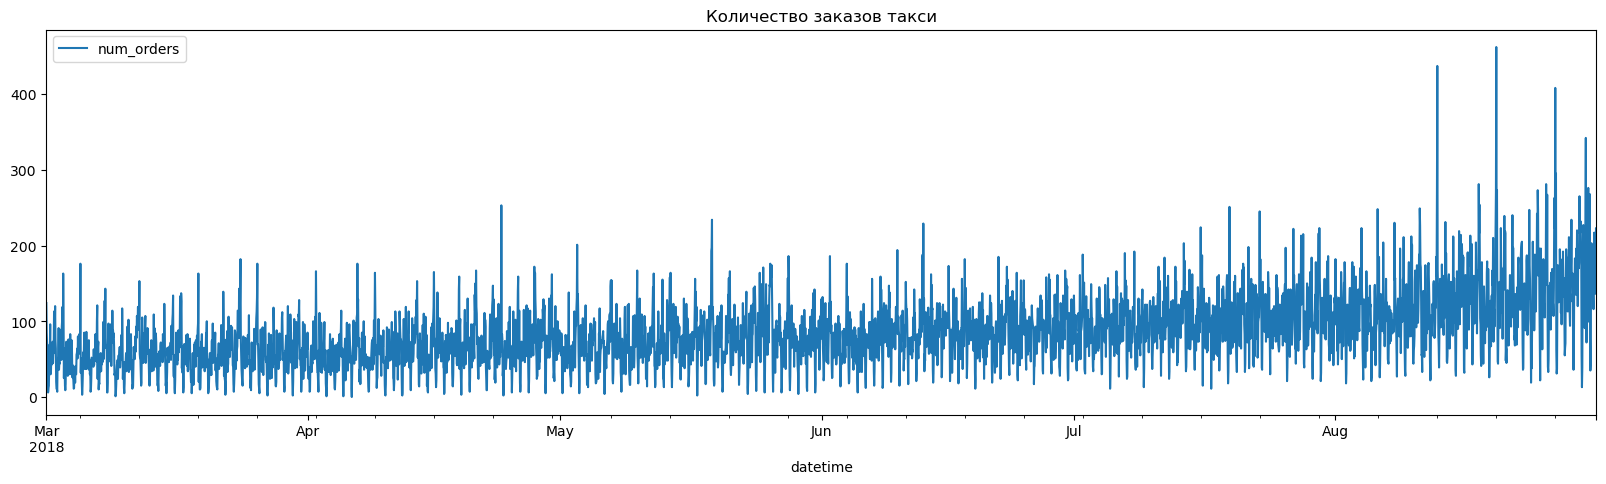

In [5]:
data=data.resample('1H').sum()
plt.figure(figsize=(20, 5))
plt.title("Количество заказов такси")
data.plot(ax=plt.gca())

__Вывод шагу 1__  
На этом шаге мы загрузили данные, отсортировали их по дате, а также был произведен ресемплинг 1 час

# Шаг 2. Предобработка и анализ данных

## 2.1 Проверка на наличие дубликатов

In [6]:
data.index.duplicated().sum()

0

## 2.2 Обработка пропусков

In [7]:
def check_missing_values(df):
    for column in df.columns:
        missing_values_count = df[column].isnull().sum()
        print(f"Столбец '{column}': {missing_values_count} пропусков")

In [8]:
check_missing_values(data)

Столбец 'num_orders': 0 пропусков


## 2.3 Визуализация

Построим тренд, остаток и сезонность 

In [9]:
decomposed = seasonal_decompose(data) 

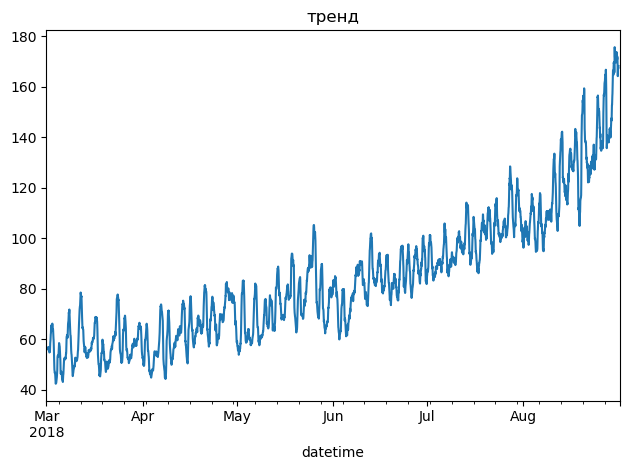

In [10]:
decomposed.trend.plot(ax=plt.gca())
plt.title('тренд')
plt.tight_layout()

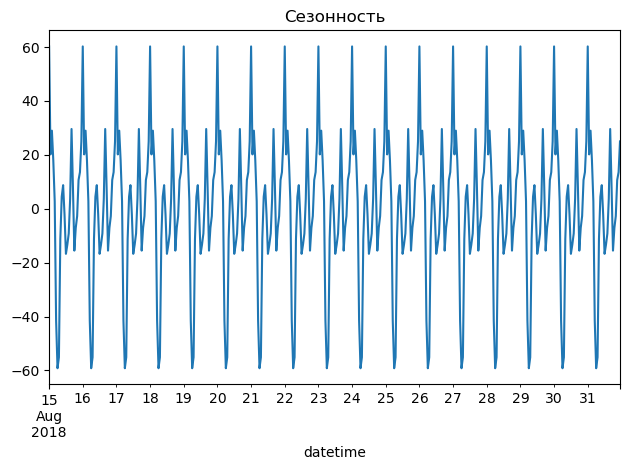

In [11]:
decomposed.seasonal['2018-08-15':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.tight_layout()

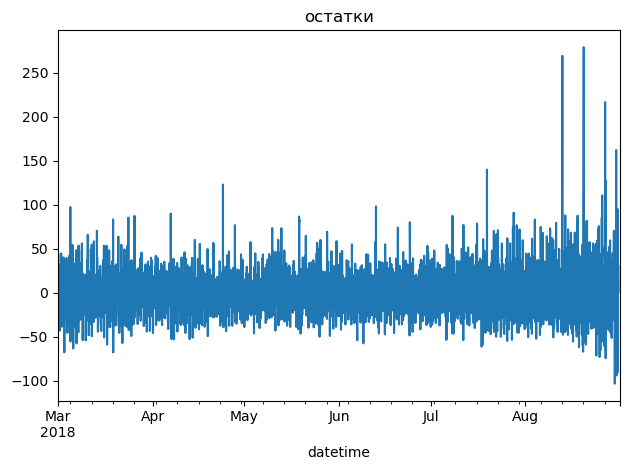

In [12]:
decomposed.resid.plot(ax=plt.gca())
plt.title('остатки')
plt.tight_layout()

Построим график с разбивкой по неделям со скользящим средним 

<Axes: title={'center': 'Количество заказов такси'}, xlabel='datetime'>

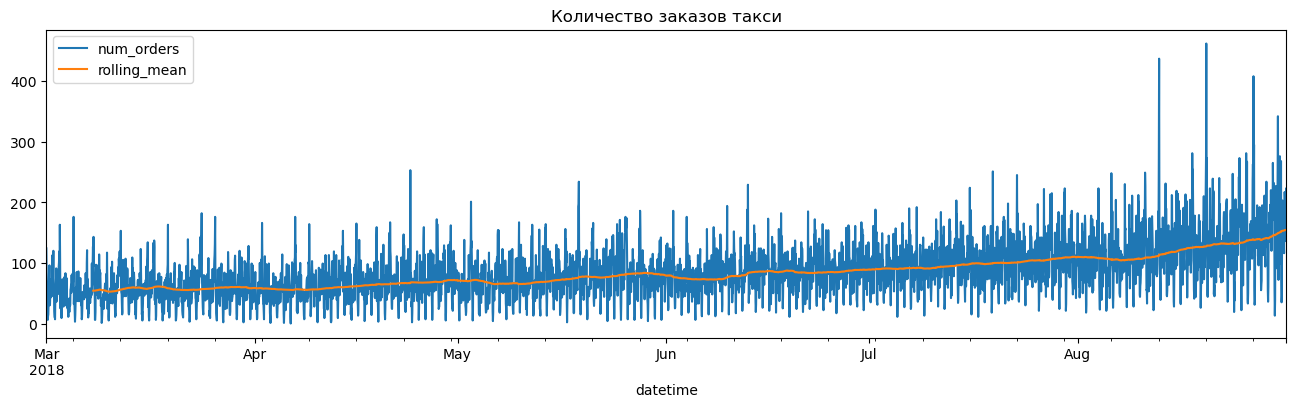

In [13]:
data['rolling_mean'] = data.rolling(168).mean()
plt.figure(figsize=(16,4))
plt.title("Количество заказов такси")
data.plot(ax=plt.gca())

Теперь рассмотрим данные за последнюю неделю и найдем для этих данных тренд, сезонность и остатки 

In [14]:
decomposed_week = seasonal_decompose(data['num_orders']['2018-08-24':'2018-08-31'])

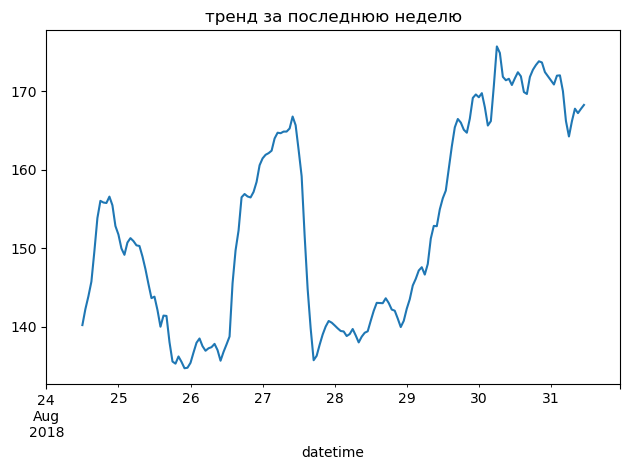

In [15]:
decomposed_week.trend.plot(ax=plt.gca())
plt.title('тренд за последнюю неделю')
plt.tight_layout()

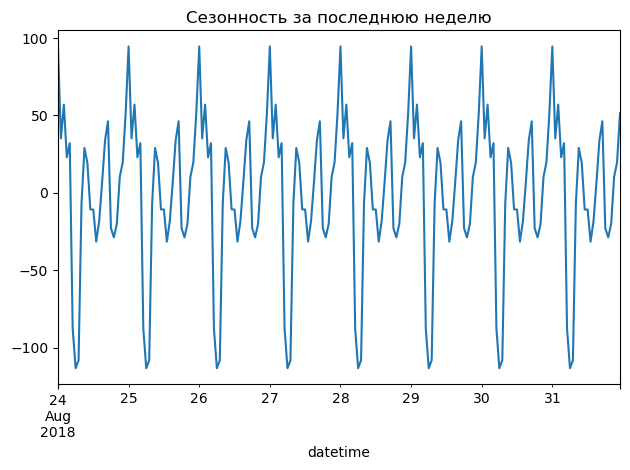

In [16]:
decomposed_week.seasonal['2018-08-15':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность за последнюю неделю')
plt.tight_layout()

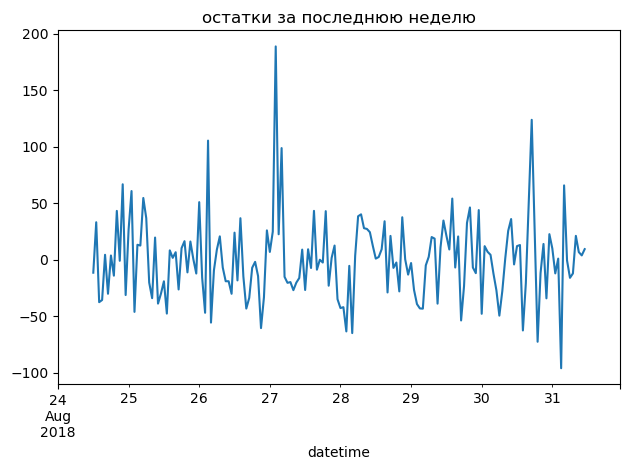

In [17]:
decomposed_week.resid.plot(ax=plt.gca())
plt.title('остатки за последнюю неделю')
plt.tight_layout()

__Вывод по шагу 2__  
В этом шаге мы проверили датафрейм на наличие дубликатов, обработали пропуски и визуализировали данные (построили графики тренда, сезонности и остатка на всех данных и за последнюю неделю, а также график с разбивкой по неделям со скользящим средним)   
Наблюдаем тренд на увеличение количества заказов в течении года, временной ряд - стационарный, присутствует недельная сезонность,пик заказов приходится на конец дня 

## Шаг 3 Обучение разных моделей с различными гиперпараметрами

In [18]:
def make_features(df: pd.DataFrame, max_lag: int, rolling_mean_size: int)-> pd.DataFrame:
    
    data = df.copy()
    data = data.drop(['rolling_mean'], axis=1)
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [19]:
data = make_features(data, 24, 7)
data = data.dropna()

Разделим данные на тренировочную и тестовую выборки

In [20]:
X = data.drop('num_orders' , axis=1)
y = data['num_orders'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)


__Моедль линейной регрессии__

Теперь начнемо бучать модели, первой будет линейная регрессия 

In [21]:
model_lr = LinearRegression()
tscv = TimeSeriesSplit(n_splits = 4)
param_grid_lr = {
    'fit_intercept': [True, False],'copy_X': [True, False],'n_jobs': [1, -1]
}

gs_lr = GridSearchCV(
    model_lr,
    param_grid=param_grid_lr,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv = tscv
)

gs_lr.fit(X_train, y_train)
best_params_lr = gs_lr.best_params_
print(f'best_score: {gs_lr.best_score_ * -1}')

print(f'best_params: {gs_lr.best_params_}')

best_score: 27.283700301190642
best_params: {'copy_X': True, 'fit_intercept': False, 'n_jobs': 1}


In [22]:
best_model_lr = LinearRegression(**best_params_lr)
best_model_lr.fit(X_train, y_train)

LinearRegression(fit_intercept=False, n_jobs=1)

In [23]:
test_predictions_lr = best_model_lr.predict(X_test)

In [24]:
rmse_lr = np.sqrt(mean_squared_error(y_test, test_predictions_lr))
rmse_lr

45.50586811023601

Видим, что линейная регрессия дала рещультат в 45.50586811023601 RMSE, что меньше 48 и нам подходит, но давайте попытаемся построить еще 2 моедли, возможно у них результат будет лучше

__Модель LightGBM__

In [25]:
model_lgbmr = LGBMRegressor()
tscv = TimeSeriesSplit(n_splits = 4)
parameters = [{'num_leaves':[50, 100, 150, 200, 250], 'learning_rate':[0.1, .25, 0.5, 0.75], 'random_state':[88]}]
grid_cv_lgbmr = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error', cv = tscv)
grid_cv_lgbmr.fit(X_train, y_train)
best_params_lgbmr = grid_cv_lgbmr.best_params_
best_params_lgbmr

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2864
[LightGBM] [Info] Number of data points in the train set: 792, number of used features: 28
[LightGBM] [Info] Start training from score 57.103535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

{'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 88}

In [26]:
model_lgbmr = LGBMRegressor(**best_params_lgbmr)
model_lgbmr.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4853
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 28
[LightGBM] [Info] Start training from score 78.451417


LGBMRegressor(num_leaves=100, random_state=88)

In [27]:
test_predictions_lgbmr = model_lgbmr.predict(X_test)

In [28]:
rmse_lgbmr = np.sqrt(mean_squared_error(y_test, test_predictions_lgbmr))
rmse_lgbmr

41.21640436302504

Модель LightGBM показала результат лучше чем линейная регрессия, теперь проверим Модель CatBoostRegressor

__Модель CatBoostRegressor__

In [29]:
model_cbr = CatBoostRegressor() 
tscv = TimeSeriesSplit(n_splits = 4)
parameters = [{'n_estimators':[1, 10, 50, 100],'learning_rate':[0.1, 0.25, 0.5, 0.75], 'random_state':[88]}]

grid_cv_cbr = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error', cv = tscv)
grid_cv_cbr.fit(X_train, y_train)

best_params_cbr = grid_cv_cbr.best_params_
best_params_cbr

0:	learn: 28.2563210	total: 159ms	remaining: 0us
0:	learn: 29.5688574	total: 4.47ms	remaining: 0us
0:	learn: 31.4050211	total: 4.11ms	remaining: 0us
0:	learn: 32.7585975	total: 5.04ms	remaining: 0us
0:	learn: 28.2563210	total: 3.58ms	remaining: 32.3ms
1:	learn: 27.3129587	total: 6.55ms	remaining: 26.2ms
2:	learn: 26.1244036	total: 9.43ms	remaining: 22ms
3:	learn: 25.1240759	total: 12.5ms	remaining: 18.8ms
4:	learn: 24.2473642	total: 15.4ms	remaining: 15.4ms
5:	learn: 23.5831462	total: 18.2ms	remaining: 12.1ms
6:	learn: 22.9706853	total: 21.2ms	remaining: 9.09ms
7:	learn: 22.3470812	total: 23.9ms	remaining: 5.96ms
8:	learn: 21.7965941	total: 26.9ms	remaining: 2.99ms
9:	learn: 21.2959121	total: 29.9ms	remaining: 0us
0:	learn: 29.5688574	total: 3.73ms	remaining: 33.6ms
1:	learn: 28.4080629	total: 6.95ms	remaining: 27.8ms
2:	learn: 27.3505838	total: 10.4ms	remaining: 24.3ms
3:	learn: 26.3953068	total: 13.8ms	remaining: 20.7ms
4:	learn: 25.5198132	total: 17.2ms	remaining: 17.2ms
5:	learn: 2

{'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 88}

In [30]:
model_cbr = CatBoostRegressor(**best_params_cbr)
model_cbr.fit(X_train, y_train)

0:	learn: 36.9800380	total: 4.72ms	remaining: 467ms
1:	learn: 35.4454327	total: 8.75ms	remaining: 429ms
2:	learn: 34.0875294	total: 12.6ms	remaining: 408ms
3:	learn: 32.8773201	total: 16.6ms	remaining: 398ms
4:	learn: 31.8038181	total: 20.5ms	remaining: 390ms
5:	learn: 30.8746834	total: 24.3ms	remaining: 381ms
6:	learn: 30.0466243	total: 28.1ms	remaining: 374ms
7:	learn: 29.3212949	total: 31.9ms	remaining: 367ms
8:	learn: 28.6600499	total: 36ms	remaining: 364ms
9:	learn: 28.0920577	total: 39.9ms	remaining: 359ms
10:	learn: 27.6102099	total: 43.5ms	remaining: 352ms
11:	learn: 27.1359397	total: 47.5ms	remaining: 348ms
12:	learn: 26.7196492	total: 51.9ms	remaining: 347ms
13:	learn: 26.3739886	total: 55.9ms	remaining: 343ms
14:	learn: 26.0771987	total: 60.2ms	remaining: 341ms
15:	learn: 25.8060699	total: 64.4ms	remaining: 338ms
16:	learn: 25.5447685	total: 68.6ms	remaining: 335ms
17:	learn: 25.3323847	total: 72.5ms	remaining: 330ms
18:	learn: 25.1453688	total: 76.4ms	remaining: 326ms
19:	l

In [31]:
test_predictions_cbr = model_cbr.predict(X_test)

In [32]:
rmse_cbr = np.sqrt(mean_squared_error(y_test, test_predictions_cbr))
rmse_cbr

44.59744325466934

__Вывод по шагу 3__  
На этом шаге мы обучили три модели Линейной регрессии, LightGBM и CatBoostRegressor на тренировочных выборках и подсчитали качестов RMSE этих моделей на тестовых выборках, анализ результатов проведем в следующем шаге.

# Шаг 4.Анализ результатов

In [33]:
results = pd.DataFrame({'Модель': ['Linear Regression', 'LightGBM', 'CatBoostRegressor'],
                        'Качество (RMSE) на тестовой выборке': [45.50586811023601, 41.21640436302504, 44.59744325466934]})

results

,Модель,Качество (RMSE) на тестовой выборке
0,Linear Regression,45.505868
1,LightGBM,40.572204
2,CatBoostRegressor,41.579796


Видим, что модель LightGBM с параметрами LGBMRegressor(num_leaves=50, random_state=88) показала лучшее качество RMSE на тестовой выборке. Качество (RMSE) на тестовой выборке этой модели равно 40.572204, что удовлетворяет указанному в задании порогоу в 48 

Построим график сравнения реальных значений и предсказанных

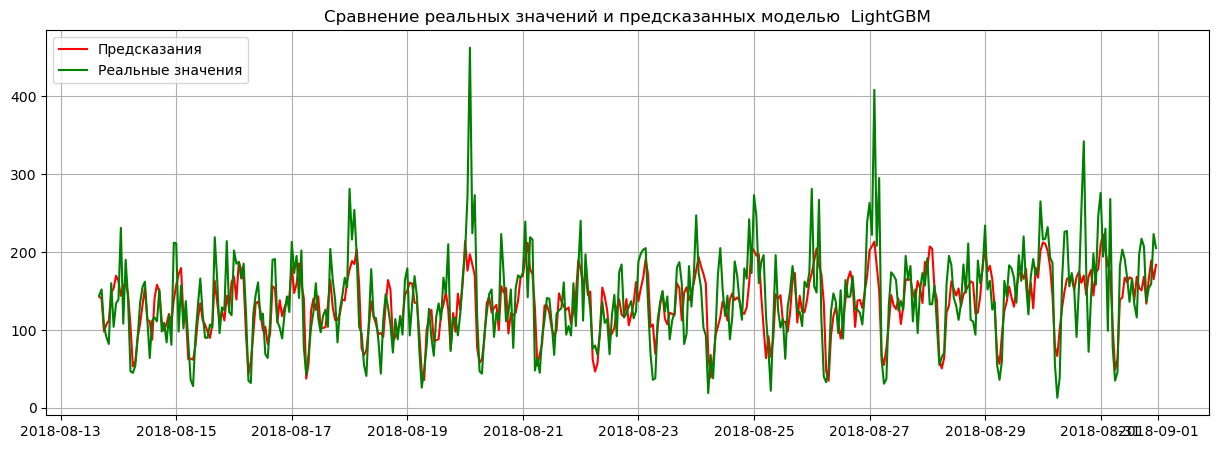

In [34]:
plt.figure(figsize=(15,5))
plt.title('Сравнение реальных значений и предсказанных моделью  LightGBM')
plt.plot(X_test.index.values, test_predictions_lgbmr, 'r', label='Предсказания')
plt.plot(X_test.index.values, y_test.values, 'g', label='Реальные значения')
plt.legend(loc="upper left")
plt.grid(True)

Визуально можем оценить, что модель хорошо предсказывает колебательные движения реальных данных.

__Вывод по шагу 4__  
На этом шаге мы создали сводную таблицу с показателями RMSE всех трех моделей и построили график сравнения реальных значений и предсказанных лучшей моделью. Ей оказалась LightGBM с показателем RMSE 40.572204 

# Вывод

В этом проекте мы спрогнозировали количество заказов такси на следующий час, построили несколько моделей для такого предсказания и выбрали лучшую на основании качества RMSE, ей оказалась LightGBM с результатом 40.572204 на тестовой выборке. Для получения такого результата были проведены: загрузка данных и выполнение их ресемплирования по одному часу, предобработка и анализ, обучения трех моделей с различными гиперпараметрами и анализ результатов
